# Market Model - Notebook
In this notebook various step by step implementations of the market model are proposed, in order to fully understand how the model is able to describe a variety of market patterns by adding different types of agents.

The mesa python library is used for this agent based modeling of markets and some sub-libraries like BaseScheduler and DataCollector are imported which allow the model to activate agents in a random order and to collect data at each timestep.

The random library is also widely used in this model to add stocasticity in a controlled way by using a fixed seed and to make the initialization data more realistic (not all agents will start with the same exact wealth, but with some random differences).

In [49]:
import mesa
from mesa.time import BaseScheduler
from mesa.datacollection import DataCollector

import random
random.seed(42)

In [50]:
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", color_codes=True, font_scale = 1)

## 1. Building Agents
There are four types of agents we decided to implement. [aggiungere testo]

### 1.1 Agent Saver
[aggiungere testo]

In [51]:
class Agent_Saver(mesa.Agent):
    def __init__(self, unique_id, model,
                 wealth, position, order,
                 wait_invest, invested):
        super().__init__(unique_id, model)
                
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2) # cash
        self.position = position # initial position, buy or sell
        self.order = order # quantities ordered
        
        # DOF Agent Saver
        self.wait_invest = wait_invest # timesteps of waiting before buying
        self.waiting = random.randint(1, 30) # not all investors invest at the sime timestap
        self.invested = invested
        
        #printing init stats
        print(f'{unique_id}: \t $ {round(self.wealth, 2)}')
        
    # Saver Functions
    # the savers keep the position since the beginning of simulation
    # and keep buying or selling during the simulation
    def invest(self):
        if self.position == 'buy':
            self.order = 5 # choose a quantity to buy
        elif self.position == 'sell':
            self.order = 5 # choose a quantity to sell
        
        # update remaining wealth
        self.wealth = self.wealth - self.order * model.Price
    
    # Step Function for saver agent
    # if they have no more wealth they're out of money to invest
    # assume savers have a constant outside income they invest periodically
    def step(self):
        if self.wealth <= 0:
            self.position = 'null'
        
        if self.invested == True:
            self.order = 0 # do not buy anymore but wait
            self.waiting -= 1
            if self.waiting == 0:
                self.invested = False
        else:
            self.wealth += 100 # income of a saver from a portion of its salary
            self.invest()
            self.invested = True
            self.waiting = self.wait_invest # reset counter for next investing

### 1.2 Agent Random Trader
[aggiungere testo]

In [52]:
class Agent_Rnd_Trader(mesa.Agent):
    def __init__(self, unique_id, model,
                 wealth, position, order):
        super().__init__(unique_id, model)
                
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2) # cash
        self.position = position # initial position, buy or sell
        self.order = order # quantities ordered
        
        #printing init stats
        print(f'{unique_id}: \t $ {round(self.wealth, 2)}')
        
    # Random Trader Functions
    def rnd_trade(self):
        if random.uniform(0,1) < 0.5:
            self.position = 'buy'
            self.order = 1 #randomize also this later
        else:
            self.position = 'sell'
            self.order = 1
        
        self.wealth = self.wealth - self.order * model.Price
        
    # Step Function for random trader agent
    def step(self):
        self.wealth += 1 
        
        if self.wealth <= 0:
            self.position = 'null'
            self.order = 0 #forse devi commentare questa parte
        
        self.rnd_trade()

### 1.3 Agent Follower
[aggiungere testo]

In [53]:
class Agent_Follower(mesa.Agent):
    def __init__(self, unique_id, model,
                 wealth, position, order,
                 wallet, detrust, p_close, p_close_thr,
                 closing_percentage, attitude):
        super().__init__(unique_id, model)
            
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2)
        self.position = position
        self.order = order
        
        # DOF Agent Follower
        self.wallet = wallet
        self.detrust = detrust
        self.p_close = p_close
        self.p_close_thr = p_close_thr * random.uniform(0.5, 1.5)
        self.closing_percentage = closing_percentage
        self.attitude = attitude

        
        #printing init stats
        print(f'{unique_id}: \t $ {round(self.wealth, 2)}\t close_thr: {round(self.p_close_thr*100,1)}%')
        
    def follow(self):
        # ... choose among all agents which one to follow
        list_agents = self.model.schedule.agents
        list_wealths = list()
        for i in range(len(list_agents)):
            list_wealths.append(list_agents[i].wealth)
        
        # create restricted list of most healthy agents
        top = 5
        top_list_idx = list()
        max_value = None        
        
        for j in range(top):
            max_value = max(list_wealths) # save max value
            max_idx = list_wealths.index(max_value) # save its index
            list_wealths[max_idx] = 0 # it's like removing it, but setting to zero maintains indices ordering
            
            top_list_idx.append(max_idx) # this list of indices makes it possible to obtain other infos on the hubs
        
        # choose an agent to follow who isn't himself
        idx_chosen = random.choice(top_list_idx)
        while list_agents[idx_chosen].unique_id == self.unique_id:
            idx_chosen = random.choice(top_list_idx)
        
        # the follower now trusts the agent he is following
        self.detrust = False        
        
        #print("Hi! I'm " + self.unique_id + " and i'm following " + list_agents[idx_chosen].unique_id)
        
        # copy the position of the chosen agent to follow
        self.position = list_agents[idx_chosen].position
        self.order = 1
        
        self.wealth = self.wealth - self.order * model.Price
        self.wallet = self.order * model.Price
        
    def check_profit(self):
        # if the follower is not satisfied with the gains he can unfollow, which means he chooses another to follow
        if self.position == 'buy':
            self.p_close = (model.Price - self.wallet)/self.wallet
        elif self.position == 'sell':
            self.p_close = (self.wallet - model.Price)/self.wallet
        
        if (model.Step_Gain < 0 and self.position == 'sell') or (model.Step_Gain > 0 and self.position == 'buy'):
            # keep position till p_close_thr is reached
            if self.p_close >= self.p_close_thr:
                self.close_position()
        else:
            #close position and set self.detrust = True
            self.close_position()
            self.detrust = True
            
    def close_position(self):
        if self.position == 'buy':
            self.position = 'sell'
            self.order = 1
        elif self.position == 'sell':
            self.position = 'buy'
            self.order = 1

        self.wealth = self.wealth + self.wallet * (1 + self.p_close)
        
    def step(self):
        self.wealth += 10
        
        if self.wealth <= 0:
            self.position = 'null'
        
        #if closing_percentage is reached and the number of agents that pass is lower than N_passing_followers, 
        #then the agent closes his own position, otherwise he goes on
        if (((abs(model.Net_Result)/100) >= self.closing_percentage) and (self.attitude == 'pass')):
            self.close_position()
        else:
            #if detrust is true then it means follower is looking for another agent to follow
            if self.detrust == True:
                self.follow()
            else:
                #check if profit was made
                self.check_profit() 
        

### 1.4 Agent Whale
[aggiungere testo]

In [54]:
class Agent_Whale(mesa.Agent):
    def __init__(self, unique_id, model,
                 wealth, position, order,
                 waiting, WLT, confidence,
                 wallet, p_close, p_close_thr, 
                 closing_percentage, attitude):
        super().__init__(unique_id, model)
               
        # DOF Agent
        self.wealth = round(wealth * ( 1. + 0.1 * random.uniform(-1, 1) ), 2)
        self.position = position
        self.order = order
        
        # DOF Agent Whale
        self.wallet = wallet
        self.WLT = WLT
        self.waiting = waiting
        self.confidence = confidence # this is the confidence in the correctness of their own strategy
        self.p_close = p_close
        self.p_close_thr = p_close_thr * random.uniform(0.9, 1.1)
        self.closing_percentage = closing_percentage
        self.attitude = attitude

    
        # printing init stats
        print(f'{unique_id}: \t $ {round(self.wealth, 2)}\t close_thr: {round(self.p_close_thr*100,1)}%\t WLT: \t{self.WLT}')        
        
    def check_strat(self):
        if model.Step_Gain < 0:
            self.position = 'buy'
            self.order = 1
            if model.Net_Result < 0:
                self.waiting +=1
            else:
                self.waiting = 0
        else:
            self.position = 'sell'
            self.order = 1
            if model.Net_Result > 0:
                self.waiting +=1
            else:
                self.waiting = 0
        
        self.wealth = self.wealth - self.order * model.Price
        self.wallet = self.order * model.Price
        
        if self.waiting >= self.WLT:
            self.confidence = False
            self.waiting = 0
            
        if self.position == 'buy':
            self.p_close = (self.wealth - self.wallet)/self.wallet
        elif self.position == 'sell':
            self.p_close = (self.wallet - self.wealth)/self.wallet
            
        if self.p_close >= self.p_close_thr:
            self.change_strategy()
            self.confidence = True
    
    def change_strategy(self):
        if self.position == 'buy':
            self.position == 'sell'
            self.order = 1
        elif self.position == 'sell':
            self.position == 'buy'
            self.order = 1
            
        self.wealth = self.wealth - self.order * model.Price
        self.wallet = self.order * model.Price
        
    def close_position(self):
        if self.position == 'sell':
            self.position = 'buy'
            self.order = 1
        elif self.position == 'buy':
            self.position = 'sell'
            self.order = 1
            
        self.wealth = self.wealth + self.wallet * (1 + self.p_close)
        
    
    def step(self):
        self.wealth += 20
        
        if self.wealth <= 0:
            self.position = 'null'
            
        if (((abs(model.Net_Result)/100) >= self.closing_percentage) and (self.attitude == 'pass')):
            self.close_position()
        else:
            if self.confidence == True:
                self.check_strat()
            else:
                self.close_position()
                self.check_strat()
          

## 2. Building Model
Before building the model class it is needed to define methods that will be used later, like change_Prices, which allows the datacollector to update prices.
The price is updated from order book data with a arbitrary coefficient.

Inside this method there are global variables such as model.Price that are also used by the agents to know at which price they are taking a sell or buy position.

In [55]:
def change_Prices(model):
    agent_wealth = [agent.wealth for agent in model.schedule.agents]
    agent_positions = [agent.position for agent in model.schedule.agents]
    agent_orders = [agent.order for agent in model.schedule.agents]
    
    sbo = 0 # sum buy orders
    sso = 0 # sum sell orders
    alfa = 0.1 # coefficient for price updating
    
    for i in range(len(agent_positions)):
        if agent_positions[i] == 'buy':
            sbo += agent_orders[i]
        elif agent_positions[i] == 'sell':
            sso += agent_orders[i]
    
    delta = alfa * (sbo - sso)
    
    model.Last_Price = model.Price
    model.Price = model.Price + delta
    model.Step_Gain = (model.Price - model.Last_Price)/model.Last_Price
    model.Net_Result = Price - model.Price
    #when Net_Result < 0 the current price is higher than the inizial price
    
    return model.Price

### 2.1 Model with only Savers

In [56]:
class Market_Model_1(mesa.Model):
    """Market Model with buyers and sellers"""

    def __init__(self, N_agents, Price,
                 p_savers, savers_sentiment):
                
        # DOF model
        self.N_agents = N_agents
        self.Price = Price
        
        # Init dynamic variables model
        self.Last_Price = self.Price
        self.Step_Gain = 0
        
        # Environment Settings
        self.schedule = BaseScheduler(self)
        self.savers_sentiment = savers_sentiment
        
        # Create Savers
        N_savers = int(N_agents * p_savers)
        wealth = 1000 
        order = 0
        wait_invest = random.randint(15, 30) # not all investors invest with the same frequency
        invested = True
        
        list_ord = list()
        #list of agents in the right order
        for i in range(N_savers):
            if i <= N_savers * savers_sentiment:
                position = 'buy'
            else:
                position = 'sell'
            
            a = Agent_Saver('saver_{}'.format(i), self, wealth, position, order, wait_invest, invested)
            list_ord.append(a)
            
        #----------------------------------------------------------------
            
        list_rand = list()
        list_rand = random.sample(list_ord, len(list_ord))
        #list of agents in random order. This list will be passed in the schedule
            
        for a_r in list_rand:
            self.schedule.add(a_r)
        
        #----------------------------------------------------------------
        
        # DATACOLLECTING
        self.datacollector = DataCollector(
            model_reporters = {'Price': change_Prices}, # here put methods for datacollecting
            agent_reporters = {
                'Wealth': 'wealth',
                'Position': 'position',
                'Order': 'order'
            }
        )
    
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        
        # Collect the data at that timestep
        self.datacollector.collect(self)

### 2.2 Model with Savers and Random Traders

In [57]:
class Market_Model_2(mesa.Model):
    """Market Model with buyers and sellers"""

    def __init__(self, N_agents, Price,
                 p_savers, savers_sentiment):
                
        # DOF model
        self.N_agents = N_agents
        self.Price = Price
        
        # Init model dynamic variables
        self.Last_Price = self.Price
        self.Step_Gain = 0
        
        # Environment Settings
        self.schedule = BaseScheduler(self)
        self.savers_sentiment = savers_sentiment
        
        #----------------------------------------------------------------
        
        # Create Savers
        N_savers = int(N_agents * p_savers)
        wealth = 1000 
        order = 0
        wait_invest = random.randint(15, 30) # not all investors invest with the same frequency
        invested = True
        
        list_ord = list()
        #list of agents in the right order
        for i in range(N_savers):
            if i <= N_savers * savers_sentiment:
                position = 'buy'
            else:
                position = 'sell'
            
            a = Agent_Saver('saver_{}'.format(i), self, wealth, position, order, wait_invest, invested)
            list_ord.append(a)

        #----------------------------------------------------------------

        # Create Random Traders
        N_rnd_traders = N_agents - N_savers
        wealth = 400
        order = 0
        position = 'null'
        
        for i in range(N_rnd_traders):
            a = Agent_Rnd_Trader('rnd_trader_{}'.format(i), self, wealth, position, order)
            list_ord.append(a)
            
        #----------------------------------------------------------------
            
        list_rand = list()
        list_rand = random.sample(list_ord, len(list_ord))
        #list of agents in random order. This list will be passed in the schedule
            
        for a_r in list_rand:
            self.schedule.add(a_r)
        
        #----------------------------------------------------------------
        
        # DATACOLLECTING
        self.datacollector = DataCollector(
            model_reporters = {'Price': change_Prices}, # here put methods for datacollecting
            agent_reporters = {
                'Wealth': 'wealth',
                'Position': 'position',
                'Order': 'order'
            }
        )
    
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        
        # Collect the data at that timestep
        self.datacollector.collect(self)

### 2.3 Model with Savers, Random Traders and Followers

In [58]:
class Market_Model_3(mesa.Model):
    """Market Model with buyers and sellers"""

    def __init__(self, N_agents, Price,
                 p_savers, p_followers, savers_sentiment,
                 p_passing_followers):
                
        # DOF model
        self.N_agents = N_agents
        self.Price = Price
        
        # Init dynamic variables model
        self.Last_Price = self.Price
        self.Step_Gain = 0
        self.Net_Result = 0
        
        # Environment Settings
        self.schedule = mesa.time.BaseScheduler(self)
        self.savers_sentiment = savers_sentiment
        
        #----------------------------------------------------------------
        
        # Create Savers
        N_savers = int(N_agents * p_savers)
        wealth = 1000
        order = 0
        wait_invest = random.randint(15, 30) # not all investors invest with the same frequency
        invested = True
        
        list_ord = list()
        #list of agents in the right order
        for i in range(N_savers):
            if i <= N_savers * savers_sentiment:
                position = 'buy'
            else:
                position = 'sell'
            
            a = Agent_Saver('saver_{}'.format(i), self, wealth, position, order, wait_invest, invested)
            list_ord.append(a)
        
        #----------------------------------------------------------------

        # Create Followers
        N_followers = int(N_agents * p_followers)
        N_passing_followers = int(N_followers * p_passing_followers)
        wealth = 600
        order = 0
        position = 'null'
        wallet = 0
        detrust = False
        p_close = 0
        p_close_thr = 0.10
        closing_percentage = 0.025
        
        for i in range(N_followers):
            if i <= N_passing_followers:
                attitude = 'pass'
            else:
                attitude = 'go on'
        
        for i in range(N_followers):
            a = Agent_Follower('follower_{}'.format(i), self, wealth, position, order, wallet, detrust, p_close, p_close_thr, 
                               closing_percentage, attitude)
            list_ord.append(a)
        
        #----------------------------------------------------------------

        # Create Random Traders
        N_rnd_traders = N_agents - N_savers - N_followers
        wealth = 400
        order = 0
        position = 'null'
        
        for i in range(N_rnd_traders):
            a = Agent_Rnd_Trader('rnd_trader_{}'.format(i), self, wealth, position, order)
            list_ord.append(a)
            
        #----------------------------------------------------------------
            
        list_rand = list()
        list_rand = random.sample(list_ord, len(list_ord))
        #list of agents in random order. This list will be passed in the schedule
            
        for a_r in list_rand:
            self.schedule.add(a_r)
        
        #----------------------------------------------------------------
        
        # DATACOLLECTING
        self.datacollector = DataCollector(
            model_reporters = {'Price': change_Prices}, # here put methods for datacollecting
            agent_reporters = {
                'Wealth': 'wealth',
                'Position': 'position',
                'Order': 'order'
            }
        )
    
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        
        # Collect the data at that timestep
        self.datacollector.collect(self)

### 2.4 Model with Savers, Random Traders, Followers and Whales

In [59]:
class Market_Model_4(mesa.Model):
    """Market Model with buyers and sellers"""

    def __init__(self, N_agents, Price,
                 p_savers, p_followers, p_whales, savers_sentiment, 
                 p_passing_followers, p_passing_whales):
        
        self.running = True # for batch-running
        #random.seed(42)
        
        # DOF model
        self.N_agents = N_agents
        self.Price = Price
        
        # Init dynamic variables model
        self.Last_Price = self.Price
        self.Step_Gain = 0
        self.Net_Result = 0
        
        # Environment Settings
        self.schedule = mesa.time.BaseScheduler(self)
        self.savers_sentiment = savers_sentiment
        
        #----------------------------------------------------------------
        
        # Create Savers
        N_savers = int(N_agents * p_savers)
        wealth = 1000
        order = 0
        wait_invest = random.randint(15, 30) # not all investors invest with the same frequency
        invested = True
        
        list_ord = list()
        #list of agents in the right order
        for i in range(N_savers):
            if i <= N_savers * savers_sentiment:
                position = 'buy'
            else:
                position = 'sell'
            
            a = Agent_Saver('saver_{}'.format(i), self, wealth, position, order, wait_invest, invested)
            list_ord.append(a)
        
        #----------------------------------------------------------------

        # Create Followers
        N_followers = int(N_agents * p_followers)
        N_passing_followers = int(N_followers * p_passing_followers)
        wealth = 600
        order = 0
        position = 'null'
        wallet = 0
        detrust = False
        p_close = 0
        p_close_thr = 0.10
        closing_percentage = 0.025
        
        for i in range(N_followers):
            if i <= N_passing_followers:
                attitude = 'pass'
            else:
                attitude = 'go on'
        
        for i in range(N_followers):
            a = Agent_Follower('follower_{}'.format(i), self, wealth, position, order, wallet, detrust, p_close, p_close_thr, 
                               closing_percentage, attitude)
            list_ord.append(a)
        
        #----------------------------------------------------------------
        
        # Create Whales
        N_whales = int(N_agents * p_whales)
        N_passing_whales = int(N_whales * p_passing_whales)
        wealth = 10000
        order = 0
        position = 'null'
        waiting = 0
        WLT = 10 # consecutive whale losses tollerated
        confidence = True
        wallet = 0
        p_close = 0
        p_close_thr = 1.0
        closing_percentage = 0.05
        
        for i in range(N_whales):
            if i <= N_passing_whales:
                attitude = 'pass'
            else:
                attitude = 'go on'
        
        for i in range(N_whales):
            a = Agent_Whale('whale_{}'.format(i), self, wealth, position, order, waiting, WLT, confidence,
                            wallet, p_close, p_close_thr, closing_percentage, attitude)
            list_ord.append(a)
        
        #----------------------------------------------------------------

        # Create Random Traders
        N_rnd_traders = N_agents - N_savers - N_followers - N_whales
        wealth = 400
        order = 0
        position = 'null'
        
        for i in range(N_rnd_traders):
            a = Agent_Rnd_Trader('rnd_trader_{}'.format(i), self, wealth, position, order)
            list_ord.append(a)
        
        #----------------------------------------------------------------
            
        list_rand = list()
        list_rand = random.sample(list_ord, len(list_ord))
        #list of agents in random order. This list will be passed in the schedule
            
        for a_r in list_rand:
            self.schedule.add(a_r)
        
        #----------------------------------------------------------------
        
        # DATACOLLECTING
        self.datacollector = DataCollector(
            model_reporters = {'Price': change_Prices}, # here put methods for datacollecting
            agent_reporters = {
                'Wealth': 'wealth',
                'Position': 'position',
                'Order': 'order'
            }
        )
    
    def step(self):
        """Advance the model by one step."""
        self.schedule.step()
        
        # Collect the data at that timestep
        self.datacollector.collect(self)

## 3. Running the Models

### 3.1 Running Model with only Savers

In [60]:
N_agents = 10
Price = 10
Last_Price = Price
p_savers = 1.
savers_sentiment = 0.70

model = Market_Model_1(N_agents, Price, p_savers, savers_sentiment)

N_steps = 100
for i in range(N_steps):
    model.step()

saver_0: 	 $ 905.0
saver_1: 	 $ 948.98
saver_2: 	 $ 1047.29
saver_3: 	 $ 1048.13
saver_4: 	 $ 917.39
saver_5: 	 $ 906.36
saver_6: 	 $ 943.73
saver_7: 	 $ 1020.4
saver_8: 	 $ 939.77
saver_9: 	 $ 1040.26


In [61]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

<AxesSubplot: >

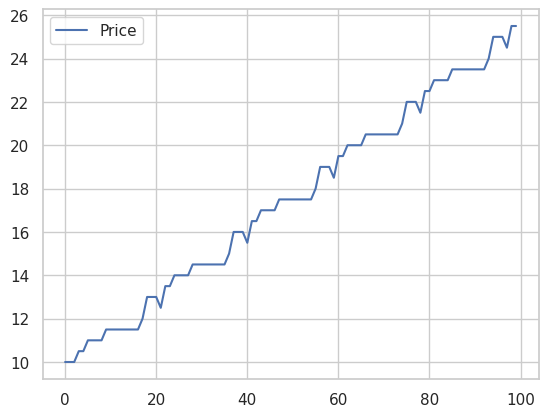

In [62]:
model_vars.plot()

It is observed that since savers are given a periodic behaviour of investing in the same position but with different frequencies then a trivial price trend pattern is a natural result in the direction of savers sentiment, which is a given model parameter.

### 3.2 Running Model with Savers and Random Traders

In [63]:
N_agents = 30
Price = 10
Last_Price = Price
p_savers = 0.8
savers_sentiment = 0.70

model = Market_Model_2(N_agents, Price, p_savers, savers_sentiment)

N_steps = 100
for i in range(N_steps):
    model.step()

saver_0: 	 $ 1091.44
saver_1: 	 $ 920.44
saver_2: 	 $ 919.34
saver_3: 	 $ 968.79
saver_4: 	 $ 1061.43
saver_5: 	 $ 991.88
saver_6: 	 $ 1094.62
saver_7: 	 $ 915.76
saver_8: 	 $ 1065.88
saver_9: 	 $ 1077.09
saver_10: 	 $ 1015.47
saver_11: 	 $ 913.91
saver_12: 	 $ 945.58
saver_13: 	 $ 1097.04
saver_14: 	 $ 946.56
saver_15: 	 $ 976.03
saver_16: 	 $ 1027.14
saver_17: 	 $ 932.53
saver_18: 	 $ 941.9
saver_19: 	 $ 1040.36
saver_20: 	 $ 1029.61
saver_21: 	 $ 1027.0
saver_22: 	 $ 1045.83
saver_23: 	 $ 992.45
rnd_trader_0: 	 $ 439.16
rnd_trader_1: 	 $ 411.2
rnd_trader_2: 	 $ 404.56
rnd_trader_3: 	 $ 414.77
rnd_trader_4: 	 $ 427.43
rnd_trader_5: 	 $ 422.08


In [64]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

<AxesSubplot: >

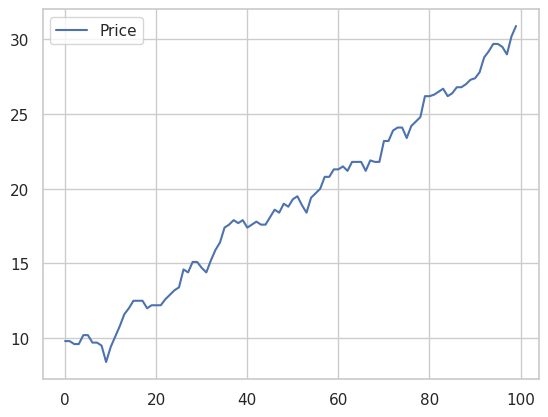

In [65]:
model_vars.plot()

In market with only savers and random traders one must pay attention to the amount of random traders and how much they can afford to exchange, this behaviour is controlled with self.order and p_savers.

Assuming that savers invest more than a random trader, which means that savers influence the price more (self.order for them is higher), it is observed that the price trend given by savers_sentiment persists but with some noise given by random tranders.

If self.order for savers is not high enough one observes that price trend is broken by random price oscillations and in some runs it may even invert the previous trend.

In [66]:
display(agent_vars)
agent_vars.to_csv('agent_vars.csv')

Wealth Position  Order
Step AgentID                              
1    saver_7        915.76      buy      0
     rnd_trader_2   395.56     sell      1
     saver_1        920.44      buy      0
     rnd_trader_1   402.20     sell      1
     saver_10      1015.47      buy      0
...                    ...      ...    ...
100  saver_16      1076.14      buy      0
     rnd_trader_3 -1372.33      buy      1
     saver_0       1099.44      buy      5
     saver_5       1036.88      buy      0
     rnd_trader_5 -1365.02      buy      1

[3000 rows x 3 columns]

### 3.3 Running Model with Savers, Random Traders and Followers

In [67]:
N_agents = 30
Price = 10
Last_Price = Price
p_savers = 0.6
p_followers = 0.2
savers_sentiment = 0.70
p_passing_followers = 0.7

model = Market_Model_3(N_agents, Price, p_savers, p_followers, savers_sentiment, p_passing_followers)

N_steps = 100
for i in range(N_steps):
    model.step()

saver_0: 	 $ 1041.39
saver_1: 	 $ 1071.92
saver_2: 	 $ 1037.48
saver_3: 	 $ 952.91
saver_4: 	 $ 1025.01
saver_5: 	 $ 1060.78
saver_6: 	 $ 985.03
saver_7: 	 $ 944.96
saver_8: 	 $ 1081.68
saver_9: 	 $ 928.45
saver_10: 	 $ 933.18
saver_11: 	 $ 1019.01
saver_12: 	 $ 1013.84
saver_13: 	 $ 987.83
saver_14: 	 $ 1037.74
saver_15: 	 $ 980.5
saver_16: 	 $ 1000.09
saver_17: 	 $ 987.55
follower_0: 	 $ 544.78	 close_thr: 9.3%
follower_1: 	 $ 578.68	 close_thr: 7.5%
follower_2: 	 $ 550.96	 close_thr: 14.6%
follower_3: 	 $ 640.32	 close_thr: 10.8%
follower_4: 	 $ 654.09	 close_thr: 15.0%
follower_5: 	 $ 620.67	 close_thr: 7.7%
rnd_trader_0: 	 $ 363.22
rnd_trader_1: 	 $ 420.5
rnd_trader_2: 	 $ 397.64
rnd_trader_3: 	 $ 412.12
rnd_trader_4: 	 $ 433.29
rnd_trader_5: 	 $ 374.52


In [68]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

<AxesSubplot: >

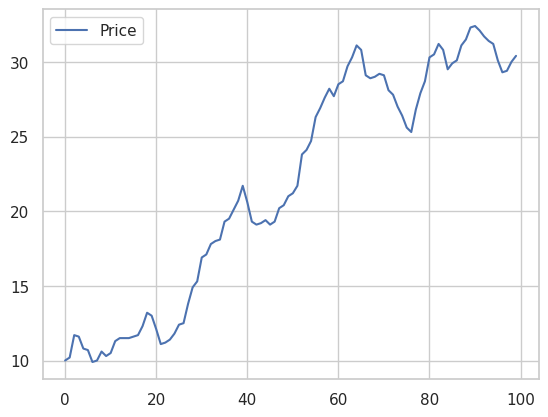

In [69]:
model_vars.plot()

In [22]:
display(agent_vars)
agent_vars.to_csv('agent_vars.csv')

Wealth Position  Order
Step AgentID                              
1    follower_0     554.78     null      0
     saver_13       987.83     sell      0
     follower_2     560.96     null      0
     rnd_trader_2   388.64     sell      1
     saver_15       980.50     sell      0
...                    ...      ...    ...
100  saver_17       923.55     sell      0
     saver_12       985.84      buy      0
     saver_14       994.74     sell      0
     saver_1       1091.42      buy      0
     rnd_trader_5 -1677.68     sell      1

[3000 rows x 3 columns]

### 3.4 Running Model with Savers, Random Traders, Followers and Whales

In [22]:
N_agents = 40
Price = 10
Last_Price = Price
p_savers = 0.2
p_followers = 0.1
p_whales = 0.05
savers_sentiment = 0.70
p_passing_followers = 0.7
p_passing_whales = 0.5

model = Market_Model_4(N_agents, Price, p_savers, p_followers, p_whales, savers_sentiment, p_passing_followers, p_passing_whales)

N_steps = 730
for i in range(N_steps):
    model.step()

saver_0: 	 $ 967.81
saver_1: 	 $ 999.24
saver_2: 	 $ 973.47
saver_3: 	 $ 1003.86
saver_4: 	 $ 916.52
saver_5: 	 $ 915.79
saver_6: 	 $ 1099.02
saver_7: 	 $ 1009.09
follower_0: 	 $ 552.31	 close_thr: 8.3%
follower_1: 	 $ 575.48	 close_thr: 9.5%
follower_2: 	 $ 626.12	 close_thr: 6.7%
follower_3: 	 $ 593.27	 close_thr: 9.5%
whale_0: 	 $ 10453.63	 close_thr: 108.2%	 WLT: 	10
whale_1: 	 $ 10229.7	 close_thr: 98.7%	 WLT: 	10
rnd_trader_0: 	 $ 411.16
rnd_trader_1: 	 $ 423.32
rnd_trader_2: 	 $ 364.59
rnd_trader_3: 	 $ 413.69
rnd_trader_4: 	 $ 392.5
rnd_trader_5: 	 $ 401.05
rnd_trader_6: 	 $ 419.99
rnd_trader_7: 	 $ 372.8
rnd_trader_8: 	 $ 362.49
rnd_trader_9: 	 $ 427.89
rnd_trader_10: 	 $ 414.25
rnd_trader_11: 	 $ 395.05
rnd_trader_12: 	 $ 370.1
rnd_trader_13: 	 $ 378.88
rnd_trader_14: 	 $ 411.61
rnd_trader_15: 	 $ 388.97
rnd_trader_16: 	 $ 435.96
rnd_trader_17: 	 $ 362.59
rnd_trader_18: 	 $ 372.28
rnd_trader_19: 	 $ 395.99
rnd_trader_20: 	 $ 389.68
rnd_trader_21: 	 $ 395.52
rnd_trader_22: 	 $

In [23]:
agent_vars = model.datacollector.get_agent_vars_dataframe()
model_vars = model.datacollector.get_model_vars_dataframe()

<AxesSubplot: >

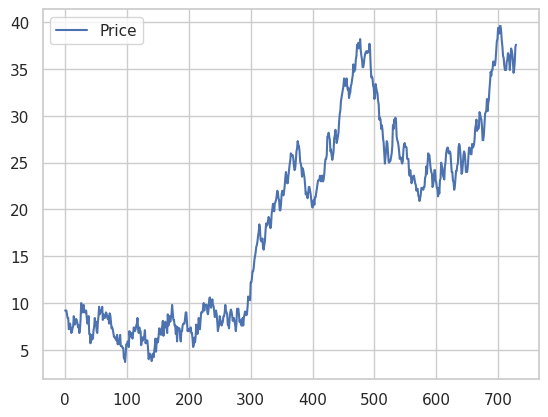

In [24]:
model_vars.plot()

In [25]:
model_vars.to_csv('model_vars.csv')

In a market simulation, if the main objective is to observe a pretty realistic chart, then one should keep high the percentage of random traders.

Instead if one wants to capture the noiseless trend given by savers, followers and whales effects on price dynamics the percentage of random traders should be kept small.

## 4. Batch-Run

In [27]:
import numpy as np

In [28]:
N_agents = 40
Price = 10
Last_Price = Price
p_savers = 0.20
p_followers = 0.10
p_whales = 0.05
savers_sentiment = 0.60
p_passing_followers = 0.7
p_passing_whales = 0.5

prm_grid = {
    'N_agents': N_agents,
    'Price': Price,
    'p_savers': p_savers,
    'p_followers': p_followers,
    'p_whales': p_whales,
    'p_passing_followers': p_passing_followers,
    'p_passing_whales': p_passing_whales,
    'savers_sentiment': np.arange(0.20, 1.00, 0.10)
}

In [29]:
results = mesa.batch_run(
    Market_Model_4,
    parameters=prm_grid,
    iterations=100,
    max_steps=200,
    number_processes=1,
    data_collection_period=1,
    display_progress=False
)

saver_0: 	 $ 1014.9
saver_1: 	 $ 937.33
saver_2: 	 $ 908.33
saver_3: 	 $ 1043.32
saver_4: 	 $ 908.6
saver_5: 	 $ 1093.4
saver_6: 	 $ 1083.45
saver_7: 	 $ 1086.89
follower_0: 	 $ 578.6	 close_thr: 13.1%
follower_1: 	 $ 657.78	 close_thr: 10.9%
follower_2: 	 $ 556.45	 close_thr: 8.2%
follower_3: 	 $ 629.66	 close_thr: 14.6%
whale_0: 	 $ 9563.03	 close_thr: 95.7%	 WLT: 	10
whale_1: 	 $ 9658.76	 close_thr: 100.3%	 WLT: 	10
rnd_trader_0: 	 $ 369.95
rnd_trader_1: 	 $ 361.3
rnd_trader_2: 	 $ 404.88
rnd_trader_3: 	 $ 417.47
rnd_trader_4: 	 $ 407.62
rnd_trader_5: 	 $ 387.83
rnd_trader_6: 	 $ 388.03
rnd_trader_7: 	 $ 376.91
rnd_trader_8: 	 $ 430.91
rnd_trader_9: 	 $ 427.62
rnd_trader_10: 	 $ 420.97
rnd_trader_11: 	 $ 391.85
rnd_trader_12: 	 $ 392.49
rnd_trader_13: 	 $ 429.36
rnd_trader_14: 	 $ 407.77
rnd_trader_15: 	 $ 414.87
rnd_trader_16: 	 $ 371.95
rnd_trader_17: 	 $ 399.47
rnd_trader_18: 	 $ 399.6
rnd_trader_19: 	 $ 385.19
rnd_trader_20: 	 $ 392.59
rnd_trader_21: 	 $ 360.97
rnd_trader_22: 	 

In [30]:
results_df = pd.DataFrame(results)
display(results_df)

,RunId,iteration,Step,N_agents,Price,p_savers,p_followers,p_whales,p_passing_followers,p_passing_whales,savers_sentiment,AgentID,Wealth,Position,Order
0,0,0,0,40,9.8,0.2,0.1,0.05,0.7,0.5,0.2,NaN,NaN,NaN,NaN
1,0,0,1,40,9.4,0.2,0.1,0.05,0.7,0.5,0.2,rnd_trader_5,351.23,sell,1.0
2,0,0,1,40,9.4,0.2,0.1,0.05,0.7,0.5,0.2,rnd_trader_20,355.99,buy,1.0
3,0,0,1,40,9.4,0.2,0.1,0.05,0.7,0.5,0.2,rnd_trader_13,392.76,buy,1.0
4,0,0,1,40,9.4,0.2,0.1,0.05,0.7,0.5,0.2,saver_1,937.33,buy,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6400795,799,99,200,40,124.0,0.2,0.1,0.05,0.7,0.5,0.9,follower_1,2613.44,buy,1.0
6400796,799,99,200,40,124.0,0.2,0.1,0.05,0.7,0.5,0.9,rnd_trader_25,-6914.64,buy,1.0
6400797,799,99,200,40,124.0,0.2,0.1,0.05,0.7,0.5,0.9,rnd_trader_0,-6934.20,sell,1.0
6400798,799,99,200,40,124.0,0.2,0.1,0.05,0.7,0.5,0.9,saver_2,342.59,buy,0.0


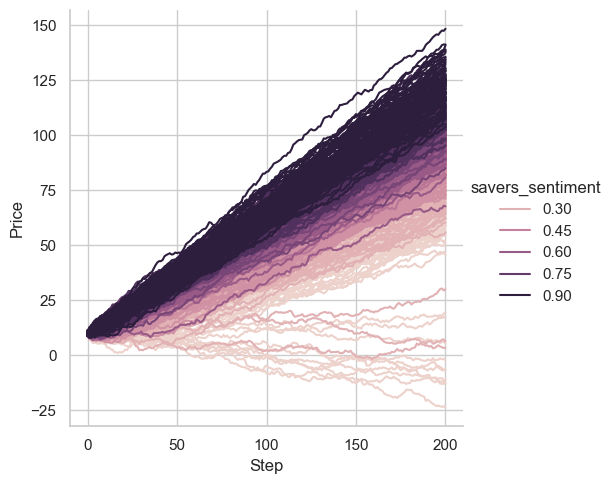

In [31]:
sns.relplot(
    data = results_df, kind = 'line',
    x = 'Step', y = 'Price', hue = 'savers_sentiment',
    units = 'iteration', estimator = None
)

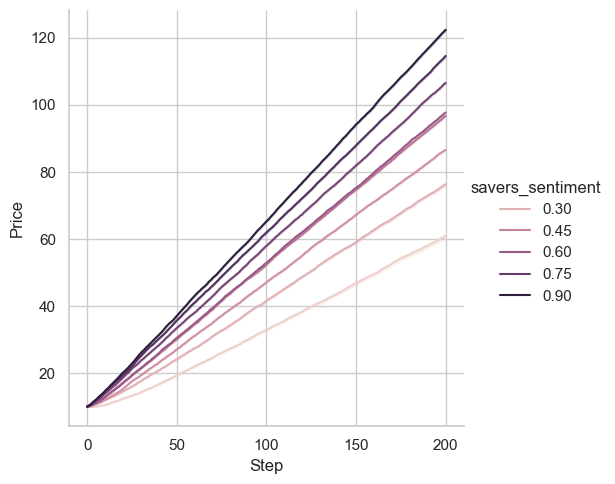

In [32]:
# this is a plot with mean values for each model parameter, with 95% confidence interval error band
sns.relplot(
    data = results_df, kind = 'line',
    x = 'Step', y = 'Price', hue = 'savers_sentiment'
)

In [33]:
_ = results_df[ results_df['savers_sentiment'] == results_df['savers_sentiment'].unique()[1]]

In [34]:
display(_)

,RunId,iteration,Step,N_agents,Price,p_savers,p_followers,p_whales,p_passing_followers,p_passing_whales,savers_sentiment,AgentID,Wealth,Position,Order
8001,1,0,0,40,9.8,0.2,0.1,0.05,0.7,0.5,0.3,NaN,NaN,NaN,NaN
8002,1,0,1,40,9.6,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_9,361.45,buy,1.0
8003,1,0,1,40,9.6,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_8,346.85,sell,1.0
8004,1,0,1,40,9.6,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_6,331.52,sell,1.0
8005,1,0,1,40,9.6,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_20,327.26,buy,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6352789,793,99,200,40,88.9,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_11,-6931.60,sell,1.0
6352790,793,99,200,40,88.9,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_10,-6946.63,buy,1.0
6352791,793,99,200,40,88.9,0.2,0.1,0.05,0.7,0.5,0.3,rnd_trader_24,-6923.12,sell,1.0
6352792,793,99,200,40,88.9,0.2,0.1,0.05,0.7,0.5,0.3,saver_2,53.75,buy,0.0


In [35]:
# But we are interested in a mean + std dev plot

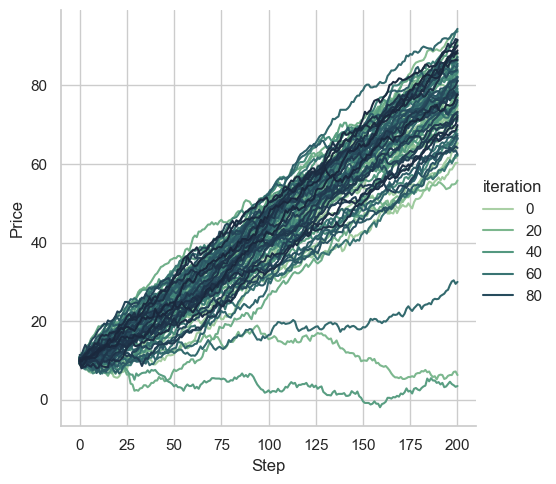

In [36]:
# Take a look at all runs for a given DOF, in this case for a given value of savers_sentiment
sns.relplot(
    data = _, kind = "line",
    x = "Step", y = "Price", hue = 'iteration', palette="ch:r=-.5,l=.75",
    estimator = None
)

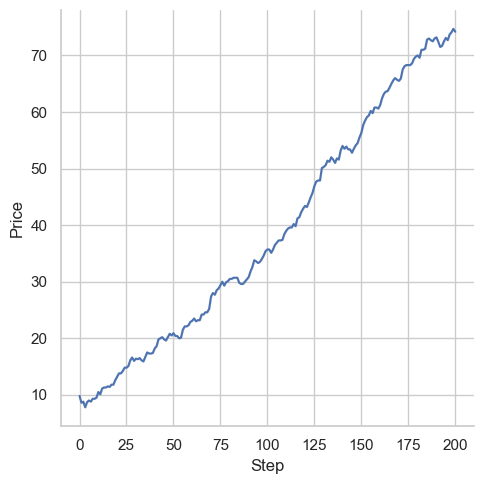

In [37]:
sns.relplot(
    data = _[ _['iteration'] == 5], kind="line",
    x="Step", y="Price",
)

In [38]:
_ = results_df[ results_df['savers_sentiment'] == results_df['savers_sentiment'].unique()[2]]

it = _['iteration'].unique().tolist()
it.pop(0)

_df = _[ _['iteration'] == 0].drop(columns = ['iteration'])
arr = np.arange(0, len(_df.dropna()), N_agents)
array_Price_values = _df.dropna().take(arr).Price.values

array_Step_values = _df.dropna().take(arr).Step.values

for el in it:
    
    _df = _[ _['iteration'] == el].drop(columns = ['iteration'])
    arr = np.arange(0, len(_df.dropna()), N_agents)
    array_Price_values_new = _df.dropna().take(arr).Price.values
    
    array_Price_values = np.vstack((array_Price_values, array_Price_values_new))

In [39]:
mean_Price_values = np.mean(array_Price_values, axis = 0)
std_Price_values = np.std(array_Price_values, axis = 0)

In [40]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

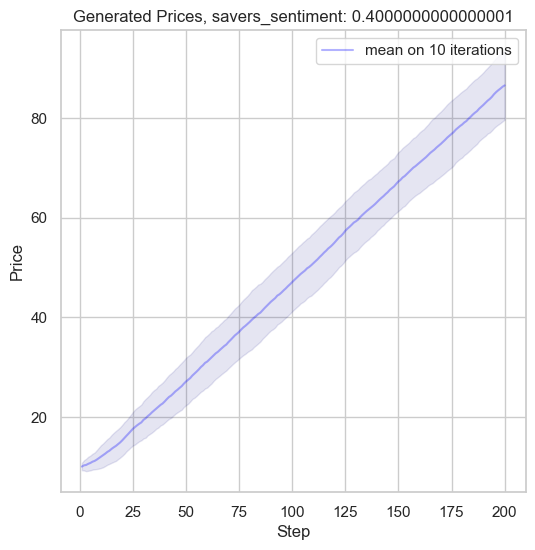

In [41]:
plt.figure()

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(array_Step_values, mean_Price_values, alpha=.3, label= 'mean on 10 iterations', color='blue')
ax.set(title = 'Generated Prices, savers_sentiment: {}'.format(results_df['savers_sentiment'].unique()[2]),
            xlabel = 'Step', ylabel = 'Price')
ax.fill_between(
    array_Step_values,
    mean_Price_values - std_Price_values,
    mean_Price_values + std_Price_values,
    alpha=0.1,
    color="navy",
    lw=1,
)

plt.legend()
plt.show()